In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

first step should be parsing the data from all the XML files and storing them in a data frame for further processing.
reference: https://towardsai.net/p/computer-vision/yolo-v5-object-detection-on-a-custom-dataset

This code block reads annotations from XML files, extracts relevant information about logos and signatures present in the image, and appends it to a list df. Here's a brief summary of what the code is doing:

1. It first initializes an empty list df and a counter cnt.

2. It uses the glob function from the glob module to obtain a sorted list of XML files in the directory tobacco_data_zhugy/groundtruth/.

3. For each XML file, it reads the root element using ET.parse(file).getroot(), where ET refers to the xml.etree.ElementTree module.

4. It extracts the original filename of the image from the src attribute of the first child element of the root element.

5. It generates a new filename for the image based on the counter cnt.

6. It extracts the page height and width from the height and width attributes of the first child element of the root element.

7. It iterates over each child element of the first child element of the root element (i.e., each "zone" element).

8. For each "zone" element, it extracts the type of zone (either "DLLogo" or "DLSignature"), the ID of the zone, the x and y coordinates of the top-left corner of the bounding box, and the width and height of the bounding box.

9. If the zone is a "DLSignature", it also extracts the author ID and a boolean indicating whether the signature overlaps with another signature in the image.

10. It appends a list containing all of this information (in the order: original filename, new filename, page height, page width, author ID, overlap, zone type, zone ID, x coordinate, y coordinate, width, height) to the list df.

11. It increments the counter cnt by 1 for the next image.

Overall, the code is essentially converting the information present in the XML files into a tabular format and storing it in a list of rows (df).

In [4]:
# Dataset Extraction from drive

df = []
cnt = 0

#setting the path of .xml files for annotation 
annotations = sorted(glob('/content/drive/MyDrive/tobacco_data_zhugy/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/*.xml'))


for file in annotations:
    myroot = ET.parse(file).getroot() #This reads the XML file using the ElementTree library and assigns the root element of the XML tree to the myroot variable.
    
    prev_filename = myroot[0].attrib['src'] #This retrieves the src attribute of the first element of the root element.
    filename = str(cnt) + '.tif' # new filename based on the count (0.tif, 1.tif etc)
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']
    
    row = []
    # An image might have multiple items (zones) (logos and signs), so iterate through each zones
    for zone in myroot[0][0]:
        category = zone.attrib['gedi_type'] # type of zone (DLLogo/ DLSignature)
        id = zone.attrib['id']
        x, y = zone.attrib['col'], zone.attrib['row'] # x, y coordinate
        w, h = zone.attrib['width'], zone.attrib['height'] # width and height of bbox
        
        # Signature have Authors, represeting whose signature it is
        if category == 'DLSignature':
            AuthorID = zone.attrib['AuthorID']
            Overlapped = zone.attrib['Overlapped']
        else:
            
            AuthorID, Overlapped = ('NA', 'NA')
        row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
        df.append(row)
    cnt += 1

In [5]:
data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'page_height', 'page_width', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height'])

In [6]:
data.head()

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110


In [7]:
test = data[['page_height', 'page_width']]

In [8]:
test

,page_height,page_width
0,3296,2560
1,3296,2560
2,2292,1728
3,3296,2560
4,2292,1728
...,...,...
1337,2156,1728
1338,2156,1728
1339,2292,1728
1340,2292,1728


In [9]:
test.max(), test.min()

(page_height    3584
 page_width     2720
 dtype: object, page_height    1575
 page_width     1200
 dtype: object)

Scaling the image to reduce training time.
To save on training time, i'm resizing the images to a maximum height and width of 640 and 480. While resizing the image, the bounding box cordinates also changes.

In [10]:
BASE_DIR = '/content/drive/MyDrive/tobacco_data_zhugy/Tobacco800_SinglePage/Tobacco800_SinglePage/SinglePageTIF/'
SAVE_PATH = '/content/drive/MyDrive/tobacco_data_zhugy/scaled/'

def scale_image(df):
    df_new = []
    filename = df.prev_filename
    X, Y, W, H = map(int, df.x), map(int, df.y), map(int, df.width), map(int, df.height)
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        image_path = BASE_DIR + file
        img = cv2.imread(image_path, 1)
        page_height, page_width = img.shape[:2]
        max_height = 640
        max_width = 480
        
        # computes the scaling factor
        if max_height < page_height or max_width < page_width:
            scaling_factor = max_height / float(page_height)
            if max_width/float(page_width) < scaling_factor:
                scaling_factor = max_width / float(page_width)
            # scale the image with the scaling factor
            img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        jpg_filename = file[:-4] + '.jpg'
        new_file_path = SAVE_PATH + jpg_filename
        cv2.imwrite(new_file_path, img) # write the scales image
        
        # save new page height and width
        page_height, page_width = page_height*scaling_factor, page_width*scaling_factor
        # compute new x, y, w, h coordinates after scaling
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new
scaled_data = scale_image(data)

In [11]:
scaled_data = list(zip(*scaled_data))

data['new_filename'] = scaled_data[0]
data['x_scaled'] = scaled_data[1]
data['y_scaled'] = scaled_data[2]
data['w_scaled'] = scaled_data[3]
data['h_scaled'] = scaled_data[4]
data['page_height_scaled'] = scaled_data[5]
data['page_width_scaled'] = scaled_data[6]
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
5,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
6,adh36e00-page2_1.tif,7.tif,3245,2560,NA,NA,DLLogo,None,1181,18,359,219,adh36e00-page2_1.jpg,221,3,67,41,608.437500,480.0
7,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431,adh36e00-page2_2.jpg,231,449,168,80,608.625000,480.0
8,adh36e00_1.tif,9.tif,3245,2560,NA,NA,DLLogo,None,1187,18,347,219,adh36e00_1.jpg,222,3,65,41,608.437500,480.0
9,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434,adh36e00_2.jpg,232,450,166,81,608.625000,480.0


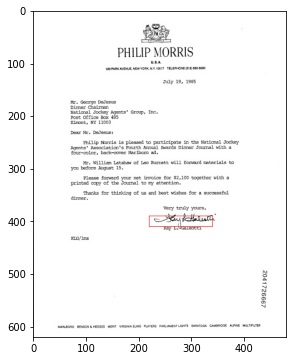

In [12]:
img = cv2.imread('/content/drive/MyDrive/tobacco_data_zhugy/scaled/arz92e00.jpg')

img = cv2.rectangle(img, (220, 390), (340, 410), (255, 0, 0), 1)
plt.figure(figsize=(6, 6))
plt.imshow(img)

In [13]:
data[['prev_filename', 'new_filename', 'filename', 'page_height', 'page_width', 'page_height_scaled', 'page_width_scaled', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height', 'x_scaled', 'y_scaled', 'w_scaled', 'h_scaled']].to_csv('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_cleaned.csv', index=False)
data.head(3)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0


#Converting data to YOLOv5 format

In [14]:
def x_center(df):
  return int(df.x_scaled + (df.w_scaled/2))
def y_center(df):
  return int(df.y_scaled + (df.h_scaled/2))

def w_norm(df, col):
  return df[col]/df['page_width_scaled']
def h_norm(df, col):
  return df[col]/df['page_height_scaled']

df = pd.read_csv('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_cleaned.csv')

le = preprocessing.LabelEncoder()
le.fit(df['category'])
print(le.classes_)
labels = le.transform(df['category'])
df['labels'] = labels


df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df.apply(w_norm, col='x_center',axis=1)
df['width_norm'] = df.apply(w_norm, col='w_scaled', axis=1)

df['y_center_norm'] = df.apply(h_norm, col='y_center',axis=1)
df['height_norm'] = df.apply(h_norm, col='h_scaled',axis=1)

df.head(1)

['DLLogo' 'DLSignature']


,prev_filename,new_filename,filename,page_height,page_width,page_height_scaled,page_width_scaled,AuthorID,Overlapped,category,...,y_scaled,w_scaled,h_scaled,labels,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,aah97e00-page02_1.tif,aah97e00-page02_1.jpg,0.tif,3296,2560,618.0,480.0,NaN,NaN,DLLogo,...,3,70,41,0,236,23,0.491667,0.145833,0.037217,0.066343


#Moving images to train and valid folders

In [15]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_valid.shape)

(1207, 26) (135, 26)


Creating directory to store yolo format data in train and valid folders using images and labels in different directories

In [16]:
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/')
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/')
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/train/')
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/valid/')

os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/')
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/train/')
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/valid/')

FileExistsError: ignored

Here we are separating data into train and valid

In [19]:
def allocate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.new_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.new_filename), os.path.join(train_img_path,row.new_filename))
 
# Apply function
src_img_path = "/content/drive/MyDrive/tobacco_data_zhugy/scaled/"
src_label_path = "/content/drive/MyDrive/tobacco_data_zhugy/groundtruth/"

train_img_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/train"
train_label_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/train"

valid_img_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/valid"
valid_label_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/valid"

allocate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
allocate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

print("No. of Training images", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/train')))
print("No. of Training labels", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/train')))

print("No. of valid images", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/valid')))
print("No. of valid labels", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/valid')))

No. of Training images 807
No. of Training labels 807
No. of valid images 129
No. of valid labels 129
